# Data Extraction for Anti-Asian Biased tweets using Twitter Search API

## Author: Luca Chun Lun Lit
### Date: Aug 22 2020

-----------------------------------------------------------------------------------------------------------------

### 1. Importing necessary packages

In [48]:
conda install -c conda-forge wordcloud


Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [51]:
conda install -c conda-forge textblob

Solving environment: done

## Package Plan ##

  environment location: /Users/loaneruser/opt/anaconda3

  added / updated specs:
    - textblob


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    textblob-0.15.3            |             py_0         595 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         595 KB

The following NEW packages will be INSTALLED:

  textblob           conda-forge/noarch::textblob-0.15.3-py_0



textblob-0.15.3      | 595 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [17]:
# importing necessary packages to connect to Twitter's API + miscellaneous data tools

import tweepy
from tweepy import OAuthHandler
import pandas as pd
import time
import os
from datetime import datetime, date, timedelta
import math

### 2. Tweepy Authentication + API connection

In [18]:

# authentication information (obtained from Twitter Developer Lab)
consumer_key = "wvrISJ5kF3i40Ul98xcDvxGEF"
consumer_secret = "11ba9Mdzx7RyLHQIV5me3d9zZ2g3fF8PsGc6shR52F0crXlbby"
access_token = "1273333809510055936-PD9haFugtPNoqtnk3GLhPsq0UmkqVy"
access_secret = "B4sl4xHWP4fsduOC2d9OIrDbDj7JGzt0WptkAuepENtmp"


# creating an OAuthHandler instance and passing it the auth. info.
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# connecting to Twitter API
api = tweepy.API(auth, wait_on_rate_limit= True, wait_on_rate_limit_notify = True)

try:
    api.verify_credentials()
    print("Authentication OK")

except:
    print("Error during authentication")


Authentication OK


### 3. Optimized Algorithm to exploit rate limits by saving tweets intermittently

In [23]:
# Function that saves tweet objects and its attributes to a pandas dataframe
# Input: a pandas dataframe and a list of tweet objects
def save_list_to_pandas(dataf, list):
    print("\nExtracting and saving tweet attributes to pandas dataframe ...")

    # TWEET ATTRIBUTES:

    # tweet_id - unique ID of the tweet
    # user.verified - boolean of whether the user is verified or not
    # user.time_zone - time_zone of user
    # user.geo_enabled - whether the user enabled geo-tracking on account
    # favorite_count - number of likes the tweet received
    # user.screen_name - username of the tweeter
    # user.location - geolocational data of where the tweet was posted - requires users to enable the location option
    # user.friends_count - number of people the user follows
    # user.followers_count - number of people following the user
    # user.statuses_count - total tweets by user
    # user.created_at - when the user account was created
    # tweet_url - URL to the tweet
    # created_at - tweet creation date and time
    # retweet_count - number of retweets
    # retweeted_status.full_text - full text of the tweet
    # entities['hashtags'] - hashtags in the tweet
    # entitities['urls'] - urls embedded in the tweet

    # Looping through the input list and extracting the attributes from each tweet
    for tweet in list:

        tweet_id = tweet.id_str
        verified = tweet.user.verified
        source = tweet.source
        in_reply_to_status_id = tweet.in_reply_to_status_id
        in_reply_to_status_id_str = tweet.in_reply_to_status_id_str
        in_reply_to_user_id = tweet.in_reply_to_user_id
        in_reply_to_user_id_str = tweet.in_reply_to_user_id_str
        in_reply_to_screen_name = tweet.in_reply_to_screen_name
        screen_name = tweet.user.name
        description = tweet.user.description
        listed_count = tweet.user.listed_count
        utc_offset = tweet.user.utc_offset
        lang = tweet.user.lang
        contributers_enabled = tweet.user.contributors_enabled
        is_translator = tweet.user.is_translator
        profile_bg_img_url = tweet.user.profile_background_image_url
        profile_bg_img_url_https = tweet.user.profile_background_image_url_https
        profile_img_url = tweet.user.profile_image_url
        profile_img_url_https = tweet.user.profile_image_url_https
        default_profile = tweet.user.default_profile
        default_profile_img = tweet.user.default_profile_image

        time_zone = tweet.user.time_zone
        geo_enabled = tweet.user.geo_enabled
        favorite_count = tweet.favorite_count
        user_id = tweet.user.id_str
        username = tweet.user.screen_name
        location = tweet.user.location
        following = tweet.user.friends_count
        followers = tweet.user.followers_count
        totaltweets = tweet.user.statuses_count
        tweet_url = "https://twitter.com/" + username + "/status/" + tweet_id
        tweetcreatedts = tweet.created_at
        retweetcount = tweet.retweet_count
        hashtags = tweet.entities['hashtags']
        mentions = tweet.entities['user_mentions']
        urls = tweet.entities['urls']

        try:  # If the tweet is a retweet
            text = tweet.retweeted_status.full_text
            retweet_status = True
        except AttributeError:  # If the tweet is not a retweet
            text = tweet.full_text
            retweet_status = False

        # create a list storing tweet attributes in the following form (indices corresponding to the pandas dataframe above)
        attr = [user_id, screen_name, username, verified, description, location, geo_enabled, time_zone,
                following, followers, totaltweets, tweetcreatedts, tweet_url,
                tweet_id, text, retweetcount, retweet_status, favorite_count,
                hashtags, mentions, urls, source, in_reply_to_status_id, in_reply_to_status_id_str,
                               in_reply_to_user_id, in_reply_to_user_id_str, in_reply_to_screen_name, listed_count, utc_offset, lang, contributers_enabled, is_translator, profile_bg_img_url, profile_bg_img_url_https, profile_img_url, profile_img_url_https, default_profile, default_profile_img]

        # add this tweet's attr to the pandas dataframe
        dataf.loc[len(dataf)] = attr

    # Notify user of how many new tweets have been saved to pandas dataframe, and how many tweets now exist in the dataframe
    print("Saved " + str(len(list)) + " tweets to pandas dataframe")
    print("Dataframe now contains " + str(len(dataf)) + " tweets")




# Function to check compute how many days have elapsed from today to a user-provided date.
# Input: a date in the format YYYY-MM-DD
# Output: The number of days elapsed
def valid_date_check(date_since, date_until):

    # Get today's date and format it to YYYY, MM, DD
    today = date.today().strftime('%Y-%m-%d')
    today_year = int(today[:4]); today_month = int(today[5:7]); today_day = int(today[8:])

    # Get the date_since and format it to YYYY, MM, DD
    since_year = int(date_since[:4]); since_month = int(date_since[5:7]); since_day = int(date_since[8:])
    d0 = date(today_year, today_month, today_day)
    d1 = date(since_year, since_month, since_day)

    # compute how many days ave elapsed between since date and today
    since_today_dayspan = d0 - d1

    until_year = int(date_until[:4]); until_month = int(date_until[5:7]); until_day = int(date_until[8:])
    d2 = date(until_year, until_month, until_day)
    since_until_dayspan = d2 - d1

    return since_today_dayspan.days, since_today_dayspan.days



# Function to scrape tweets based on a keyword, since and until date, and optional number of Tweets to scrape
# Input: (str) query words, (YYYY-MM-DD) date to be searched from, (YYYY-MM-DD) date to be searched until
def scrapetweets(search_words, date_since, date_until = ""):

    if date_until == "":
        date_until = (datetime.strptime(date_since, '%Y-%m-%d') + timedelta(1)).strftime('%Y-%m-%d')

    # If entered date_since is more than 7 days ago, Twitter is unable to retrieve the tweets
    # Below is a check to make sure a valid since date is entered
    days_elapsed = valid_date_check(date_since, date_until)

    # If greater than 7, then print error message and return
    if days_elapsed[0] > 8:
        print("\nTwitter API only allows searching for tweets published in the past 7 days. Please enter a valid date and re-run.")
        return
    elif days_elapsed[0] < 0:
        print("\nThe 'Since Date' field entered is a time in the future. Please enter a valid date and re-run.")
        return

    if days_elapsed[1] <= 0:
        print("\nInvalid 'Until Date' field entered. Date provided is either 1) before 'Since Date' or 2) same as 'Since Date'. Please enter a valid date and re-run.")
        return
    # record start_time of program
    scrap_start = time.time()
    print("\nProgram start time: " + (datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

    # Timestamp current date and time
    to_csv_timestamp = datetime.today().strftime('%Y-%m-%d_%H:%M:%S')

    # Define a pandas dataframe to store the data, with the following features:
    df = pd.DataFrame(columns=['user_id', 'screen_name','username', 'verified', 'description', 'location', 'geo_enabled', 'time_zone',
                     'following', 'followers', 'totaltweets', 'tweetcreatedts', 'tweet_url',
                     'tweet_id', 'text', 'retweetcount', 'retweet_status', 'favorite_count',
                     'hashtags', 'mentions','urls', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
                               'in_reply_to_user_id', 'in_reply_to_user_str', 'in_reply_to_screen_name', 'listed_count', 'utc_offset', 'lang', 'contributers_enabled', 'is_translator', 'profile_bg_img_url', 'profile_bg_img_url_https', 'profile_img_url', 'profile_img_url_https', 'default_profile', 'default_profile_img']
                            )

    print("\nRunning Search on:", search_words)
    print("Since: {} 00:00:00, Until {} 11:59:59".format(date_since, date_since))

    print("\nExtracting Cursor Object ...")

    # We will use the Tweepy cursor object to extract Twitter data in the form of cursor objects, which we can iterate through
    # Each item that is iterated over has common attributes that we can access (i.e. user_id, tweet_id, tweet_body)
    # Set each call to the API to retrieve 100 tweets, and return tweets in extended format.
    tweets = tweepy.Cursor(api.search, q=search_words, lang="en", count = 100, since=date_since, until=date_until,tweet_mode='extended').items()

    print("Obtained Cursor Object :", tweets)
    print("\nIterating over Tweet Objects in Cursor Object ...")
    print("Press 'Command + F2' at anytime to stop converting Tweet Objects to list")

    # Convert the tweet objects into list form
    tweet_list = []
    count = 0
    try:
        lim = api.rate_limit_status()["resources"]["search"]["/search/tweets"]["remaining"]
        if lim == 0:
            time.sleep(900)
            print("Rate Limit reached. Waiting 15 minutes to replenish rates.")
        for tweet in tweets:

            # if the rate limit is reached
            if lim < 2:
                # we know the rate limit must be reached --> therefore, we can begin saving the list to pandas dataframe while we wait for the rate to replenish
                print("Rate limit reached. Time to wait: 900 seconds")
                t1 = time.time()
                print("Saving extracted tweet data to pandas dataframe in the meanwhile ...")
                save_list_to_pandas(df, tweet_list)
                print("Latest time recorded in dataframe: ", df["tweetcreatedts"].iloc[-1])
                t2 = time.time()
                if t2 - t1 < 900:  # see how long saving takes - if it is less than 15 minutes, wait until the 15 minute mark
                    time.sleep(math.ceil(900 - (t2 - t1)))
                tweet_list = []
                time.sleep(5)
                lim = api.rate_limit_status()["resources"]["search"]["/search/tweets"]["remaining"]

            tweet_list.append(tweet)
            count += 1
            if count % 3000 == 0:
                print("Checkpoint: converted " + str(count) + " tweets")
            if count % 100 == 0:
                lim -= 1

        # if there are no more tweets to be searched, then save the rest of the list to pandas dataframe
        print("Last set of tweet data reached.")
        save_list_to_pandas(df, tweet_list)

    except KeyboardInterrupt:                               # to prevent loss of data, ctrl + C can be pressed to stop converting tweets and move on to saving data
        save_list_to_pandas(df, tweet_list)
        pass

    print('\nTweet scraping and saving to pandas dataframe complete. Total number of Tweets scraped is: {}'.format(count))
    print("Total Number of API requests made: ", math.ceil(count / 100))

    # Find the current directory path, and construct a new file under the 'data' folder
    curr_path = os.getcwd()
    filepath = curr_path + '/Anti-Asian_tweets.csv'

    # check if file already exists, and provide the user with the option to overwrite the file - or not
    if os.path.isfile(filepath):
        over_write = input('This file already exists. Would you like to overwrite it? Type Y = yes, N = no\n')
        if over_write.lower() == 'y':
            pass
        else:
            print("Results were not saved - no data overwritten.")
            return

    print('\nSaving data in .CSV format now ...')
    # Convert pandas dataframe to csv format, using the file path created above
    df.to_csv(filepath, index=False, float_format='%.13f')

    scrap_end = time.time()
    print('Complete! Saved as ' + date_since + '_tweets.csv. Total run time is {} minutes.'.format(round(scrap_end - scrap_start) / 60, 2))

    print("\nProgram end time: " + (datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
    
    return df



In [24]:
# Running the search with user-preference inputs
#search_words = '(hospital OR health OR medical OR medicine OR cure) (COVID-19 OR coronavirus OR covid OR nCov OR ncov19 OR 2019ncov OR corona)'
#search_words = '(health OR medical OR medicine OR cure) (COVID-19 OR coronavirus OR covid OR corona)'
#search_words = 'tele-health OR telehealth OR "tele health" OR televisit OR tele-visit OR "tele visit" OR "virtual healthcare" OR "virtual health care" OR "virtual care" OR virtualcare OR virtualhealthcare OR tele-medicine OR telemedicine OR "tele medicine" OR telemed OR TelemedNow OR digitalhealth OR "digital health" OR digihealth OR "remote monitoring" OR remotemonitoring OR connectedhealth OR "connected health"'

# Inspiration: https://benjamins.com/catalog/ps.14027.cro

search_words = '"china virus" OR "kung flu" OR "kungflu" OR "Wuhan" OR "chinx" OR "chinese virus" OR "Wuhan Flu" OR "chinaman" OR "china men" OR "china man" OR "chinamen" OR "ching chong" OR "chink" OR "chinavirus" OR "chinesevirus" OR "gook" OR "coolie" OR "yellowman" -filter:retweets'
#search_words = '"hate" AND ("ching chong" -filter:retweets'
#  "plague" OR "disgusting" OR "dirty" OR "gross" OR "immigrant" OR "steal" OR "stealing" "go home" OR "karma"

date_since = "2021-03-09"
date_until = "2021-03-16"

# Call the function scraptweets
data = scrapetweets(search_words, date_since, date_until)


Program start time: 2021-03-16 02:39:16

Running Search on: "china virus" OR "kung flu" OR "kungflu" OR "Wuhan" OR "chinx" OR "chinese virus" OR "Wuhan Flu" OR "chinaman" OR "china men" OR "china man" OR "chinamen" OR "ching chong" OR "chink" OR "chinavirus" OR "chinesevirus" OR "gook" OR "coolie" OR "yellowman" -filter:retweets
Since: 2021-03-09 00:00:00, Until 2021-03-09 11:59:59

Extracting Cursor Object ...
Obtained Cursor Object : <tweepy.cursor.ItemIterator object at 0x7f8d7eff0bb0>

Iterating over Tweet Objects in Cursor Object ...
Press 'Command + F2' at anytime to stop converting Tweet Objects to list
Checkpoint: converted 3000 tweets
Checkpoint: converted 6000 tweets
Checkpoint: converted 9000 tweets
Checkpoint: converted 12000 tweets


Rate limit reached. Sleeping for: 277


Rate limit reached. Time to wait: 900 seconds
Saving extracted tweet data to pandas dataframe in the meanwhile ...

Extracting and saving tweet attributes to pandas dataframe ...
Saved 13200 tweets to pandas dataframe
Dataframe now contains 13200 tweets
Latest time recorded in dataframe:  2021-03-12 11:22:39
Checkpoint: converted 15000 tweets
Checkpoint: converted 18000 tweets
Checkpoint: converted 21000 tweets
Checkpoint: converted 24000 tweets
Checkpoint: converted 27000 tweets
Last set of tweet data reached.

Extracting and saving tweet attributes to pandas dataframe ...
Saved 15208 tweets to pandas dataframe
Dataframe now contains 28408 tweets

Tweet scraping and saving to pandas dataframe complete. Total number of Tweets scraped is: 28408
Total Number of API requests made:  285
This file already exists. Would you like to overwrite it? Type Y = yes, N = no
Y

Saving data in .CSV format now ...
Complete! Saved as 2021-03-09_tweets.csv. Total run time is 548.85 minutes.

Program end 

In [39]:
data.text
conda install -c conda-forge wordcloud


SyntaxError: invalid syntax (<ipython-input-39-59defcdfee1a>, line 2)

### Word Cloud

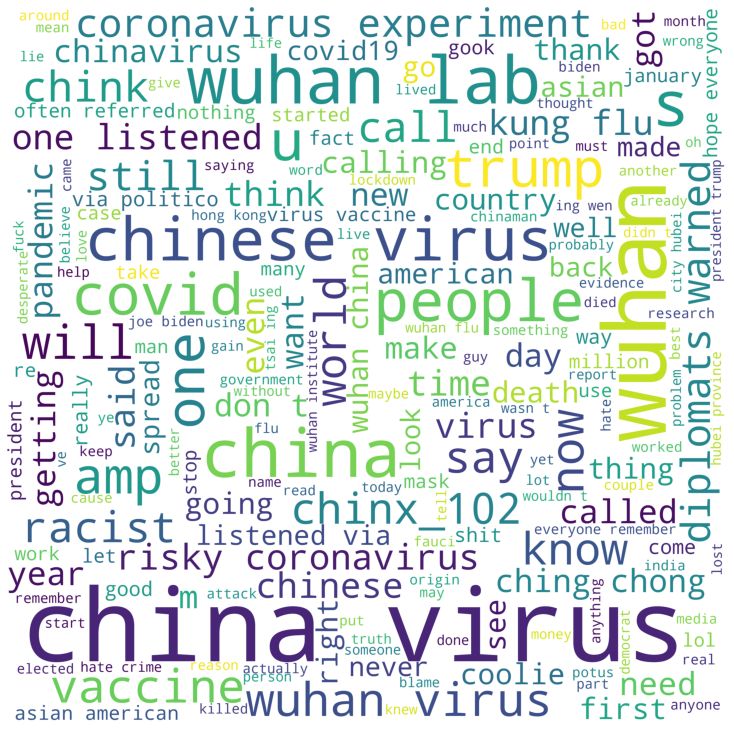

In [84]:
from wordcloud import WordCloud, STOPWORDS
import re
import matplotlib.pyplot as plt

def wordcloud(csvdata):
    df = pd.read_csv(csvdata, index_col=0)

    comment_words = ''
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for sentence in df.text:

        # typecaste each val to string
        sentence = str(sentence)
        sentence = re.sub(r'https?:\/\/\S*', '', sentence, flags=re.MULTILINE)

        # split the value
        tokens = sentence.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens) + " "

    wordcloud = WordCloud(width = 3000, height = 3000,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize=(10, 10), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()
    
wordcloud("/Users/loaneruser/Desktop/Anti-Asian_tweets.csv")

In [82]:
import pandas as pd
from collections import Counter
from textblob import TextBlob
import matplotlib.pyplot as plt


# Helper Functions:
# function to clean up excessive spacing and special characters / facial expressions

# function to remove accents from text
def remove_accents(a):
    return unidecode.unidecode(a.decode('utf-8'))

# function to remove emojis from text
def deEmojify(inputString):
    inputString = str(inputString)
    return inputString.encode('ascii', 'ignore').decode('ascii')
def clean_up(a):
    a = a.replace("<br />", " ")
    a = a.replace("\[?\[.+?\]?\]", " ")
    a = a.replace("\/{3,}", " ")
    a = a.replace("\&\#.+\&\#\d+?;", " ")
    a = a.replace("• ", "")
    a = a.replace("\d+\&\#\d+?;", " ")
    a = a.replace("\&\#\d+?;", " ")

    # handling facial expressions
    a = a.replace("\:\|", "")
    a = a.replace("\:\)", "")
    a = a.replace("\:\(", "")
    a = a.replace("\:\/", "")

    # replacing excessive spacing
    a = a.replace("\n", " ")
    a = a.replace("\s{2,}", " ")

    return a

# function that applies textblob sentiment analysis to a sentence
def textblob_sent(sentence):
    temp = TextBlob(sentence).sentiment[0]
    return round(temp, 3)

def compute_sentiment(csvdata):
    df = pd.read_csv(csvdata)
    df_final = pd.read_csv(csvdata, index_col=0)
    df = df[["text"]]
    # apply the cleaning methods above
    print("\nCleaning up tweet content...")
    df['text'] = df['text'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df["text"] = clean_up(df["text"])
    df['text'] = df["text"].str.lower()
    df['text'] = df['text'].replace('\n', ' ', regex=True)
    df['text'] = df['text'].apply(deEmojify)
    print("Cleaned.")

  
    
    sent_list = []
    # create a new column that reflects the sentiment polarity scores for each tweet
    for index, row in df.iterrows():
        sent_list.append(textblob_sent(row['text']))
    df_final['sentiment'] = sent_list
    #df_final['sentiment'] = df.apply(lambda row : textblob_sent(row['text']), axis = 1)
    #print(df_final[["sentiment"]])
    #sent_list = df_final['sentiment'].tolist()
    #print(sent_list)
    sentiment_categorized = []
    for i in sent_list:
        if i == 0:
            sentiment_categorized.append("neutral")
        elif i > 0:
            sentiment_categorized.append("positive")
        elif i < -0:
            sentiment_categorized.append("negative")
    #print(sentiment_categorized)
    df_final.loc[:, 'sentiment_category'] = sentiment_categorized
    #df['review_id'] = df.apply(lambda row : find_review_id(row['id']), axis = 1)

    print("\nDataFrame:")
    return df_final

# edited dataframe with sentiment
sent_computed_df = compute_sentiment("/Users/loaneruser/Desktop/Anti-Asian_tweets.csv")



Cleaning up tweet content...
Cleaned.

DataFrame:


Proportion of positive tweets:  35.53 %
Proportion of neutral tweets:  37.65 %
Proportion of negative tweets:  26.82 %


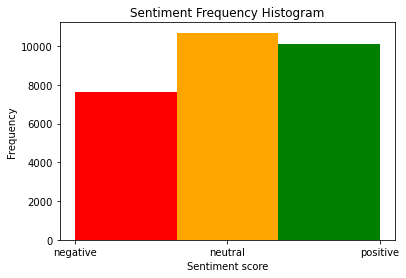

In [83]:
def sentiment_distribution(dataframe):
    sentiment_list = dataframe["sentiment_category"].tolist()
    #for i in sentiment_list:
    #    if i == 0:
    #        sent_list_in_3.append("neutral")
    #    if i > 0:
    #        sent_list_in_3.append("positive")
    #    if i < 0:
    #        sent_list_in_3.append("negative")

    total_length = len(sentiment_list)
    neutral = [i for i in sentiment_list if i == "neutral"]
    positive = [i for i in sentiment_list if i == "positive"]
    negative = [i for i in sentiment_list if i == "negative"]
    print("Proportion of positive tweets: ", round(len(positive) * 100 / total_length ,2), "%")
    print("Proportion of neutral tweets: ", round(len(neutral) * 100/ total_length, 2), "%")
    print("Proportion of negative tweets: ", round(len(negative) * 100 / total_length, 2), "%")

    sentiment_list.sort()
    
    n, bins, patches = plt.hist(sentiment_list, bins = 3, rwidth = 5)
    patches[0].set_fc("red")
    patches[1].set_fc("orange")
    patches[2].set_fc("green")
    plt.gca().set(title='Sentiment Frequency Histogram', ylabel='Frequency', xlabel= 'Sentiment score')
    plt.show()

    
sentiment_distribution(sent_computed_df)

In [41]:
# tweets published over time 
# sentiment distribution
# word cloud for positive 
# Word cloud for negative 

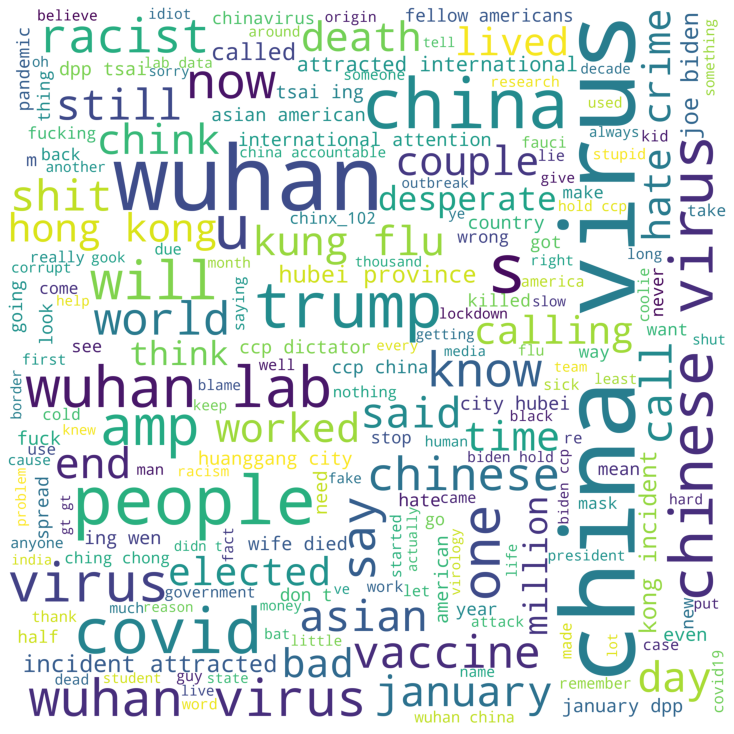

In [88]:
from wordcloud import WordCloud, STOPWORDS
import re
import matplotlib.pyplot as plt

def wordcloud(dataframe):
    df = sent_computed_df
    df = df[df["sentiment_category"] == "negative"]

    comment_words = ''
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for sentence in df.text:

        # typecaste each val to string
        sentence = str(sentence)
        sentence = re.sub(r'https?:\/\/\S*', '', sentence, flags=re.MULTILINE)

        # split the value
        tokens = sentence.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens) + " "

    wordcloud = WordCloud(width = 3000, height = 3000,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize=(10, 10), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()
    
wordcloud(sent_computed_df)